# Single Cell Analysis with Seurat

Get [Seurat](http://satijalab.org/seurat/)

In [1]:
suppressPackageStartupMessages(library(Seurat))

In [68]:
suppressPackageStartupMessages(library(ggbiplot))

In [69]:
suppressPackageStartupMessages(library(tidyverse))

In [3]:
suppressPackageStartupMessages(library(Matrix))

In [4]:
suppressPackageStartupMessages(library(factoextra))

In [5]:
options(repr.plot.width=4, repr.plot.height=3)

## Getting started 

Following official [tutorial](http://satijalab.org/seurat/get_started.html)

```bash
mkdir data/seurat
cd data/seurat
curl -O https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
tar xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
```

### Read in data

In [6]:
pbmc.data <- Read10X('data/seurat/filtered_gene_bc_matrices/hg19/')

#### Data is stored as a sparse matrix

In [7]:
class(pbmc.data)

[1] "dgTMatrix"
attr(,"package")
[1] "Matrix"

In [8]:
dim(pbmc.data)

[1] 32738  2700

#### If necessary, we can convert to data frame for inspection or manipulation

In [9]:
head(as.data.frame(as.matrix(pbmc.data[1:10, 1:6])))

,AAACATACAACCAC,AAACATTGAGCTAC,AAACATTGATCAGC,AAACCGTGCTTCCG,AAACCGTGTATGCG,AAACGCACTGGTAC
MIR1302-10,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0


### Initialize Seurat object

In [10]:
pbmc <- new("seurat", raw.data = pbmc.data)

### Filter cells

In [11]:
pbmc <- Setup(pbmc, min.cells = 3, min.genes = 200, 
              do.logNormalize = T, total.expr = 1e4, 
              project = '10X PBMC')

### Basic QC and selecting cells for further analysis

In [12]:
dim(pbmc.data)

[1] 32738  2700

#### The names are symbols for genes

In [13]:
data <- pbmc@data

In [14]:
names <- rownames(data)

In [15]:
length(names)

[1] 13714

In [16]:
head(names)

[1] "AL627309.1"    "AP006222.2"    "RP11-206L10.2" "RP11-206L10.9"
[5] "LINC00115"     "NOC2L"

In [17]:
mito.genes <- grep('^MT', names, value = T)

In [18]:
head(mito.genes)

[1] "MTOR"   "MTHFR"  "MTFR1L" "MTF1"   "MTF2"   "MTMR11"

#### `expm` is exp(x) - 1 to recover counts from `log1p` transformed data

In [19]:
percent.mito <- colSums(expm1(data[mito.genes,])/colSums(expm1(data)))

In [20]:
head(percent.mito)

AAACATACAACCAC AAACATTGAGCTAC AAACATTGATCAGC AAACCGTGCTTCCG AAACCGTGTATGCG 
    0.03100455     0.03875178     0.01080394     0.01970443     0.01428571 
AAACGCACTGGTAC 
    0.01941748

#### Store mito.percent as metadata

In [21]:
pbmc <- AddMetaData(pbmc, percent.mito, "percent.mito")

In [22]:
str(pbmc@data.info)

'data.frame':	2700 obs. of  4 variables:
 $ nGene       : int  781 1352 1131 960 522 782 783 790 533 550 ...
 $ nUMI        : num  2421 4903 3149 2639 981 ...
 $ orig.ident  : Factor w/ 1 level "10X PBMC": 1 1 1 1 1 1 1 1 1 1 ...
 $ percent.mito: num  0.031 0.0388 0.0108 0.0197 0.0143 ...


## Visualization

nUMI - number of unique molecular identifiers 

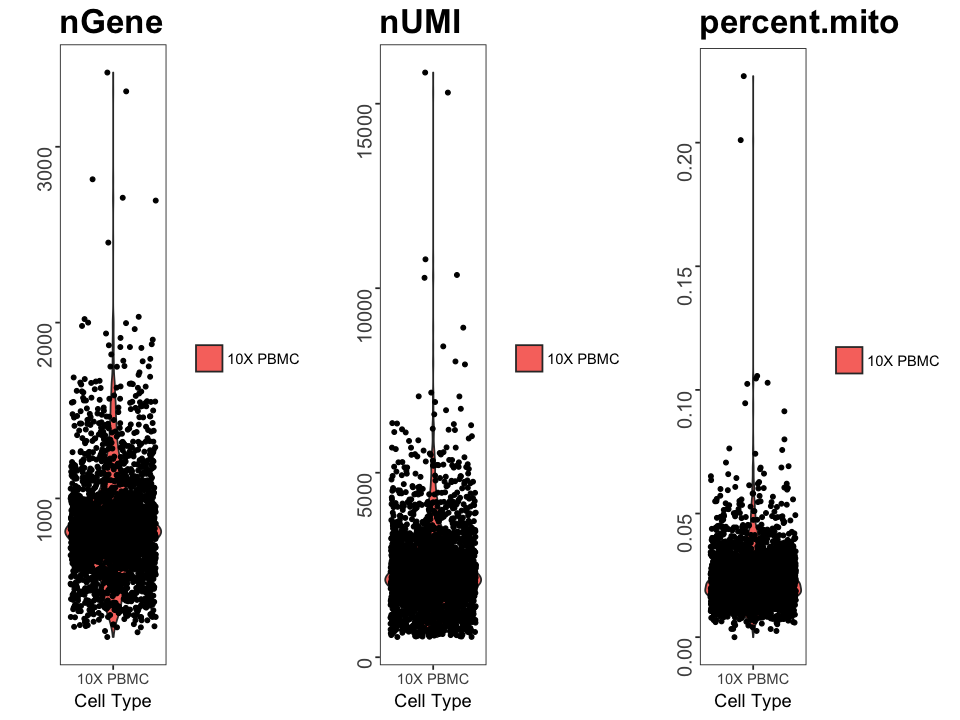

In [23]:
options(repr.plot.width=8, repr.plot.height=6)
VlnPlot(pbmc, c("nGene", "nUMI", "percent.mito"), nCol = 3)

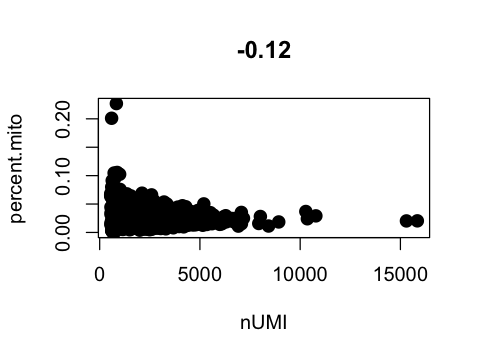

In [24]:
options(repr.plot.width=4, repr.plot.height=3)
GenePlot(pbmc, "nUMI", "percent.mito")

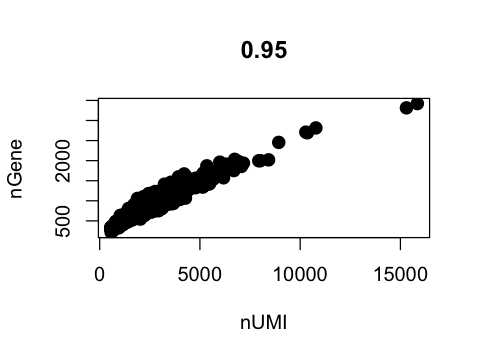

In [25]:
GenePlot(pbmc, "nUMI", "nGene")

### Making our own plots for fine control of visual impact

In [26]:
meta <- pbmc@data.info

In [27]:
head(meta, 3)

,nGene,nUMI,orig.ident,percent.mito
AAACATACAACCAC,781,2421,10X PBMC,0.03100455
AAACATTGAGCTAC,1352,4903,10X PBMC,0.03875178
AAACATTGATCAGC,1131,3149,10X PBMC,0.01080394


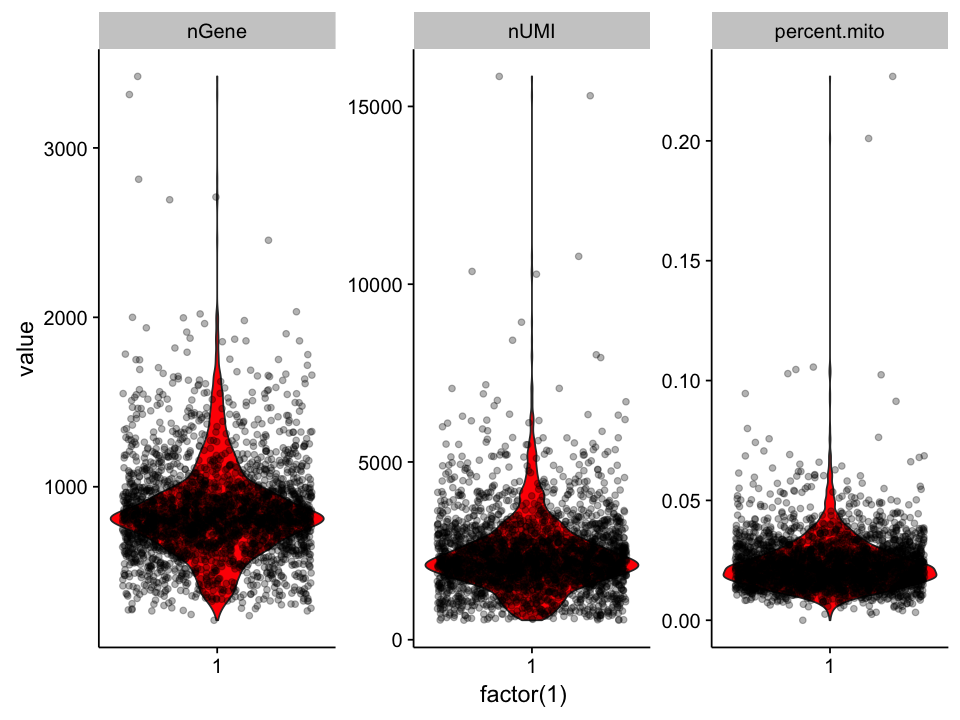

In [79]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(meta %>% select(-orig.ident) %>% 
       gather(variable, value), aes(factor(1),, y=value)) +
geom_violin(fill='red') +
geom_jitter(alpha=0.3) + 
facet_wrap(~ variable, scales='free')

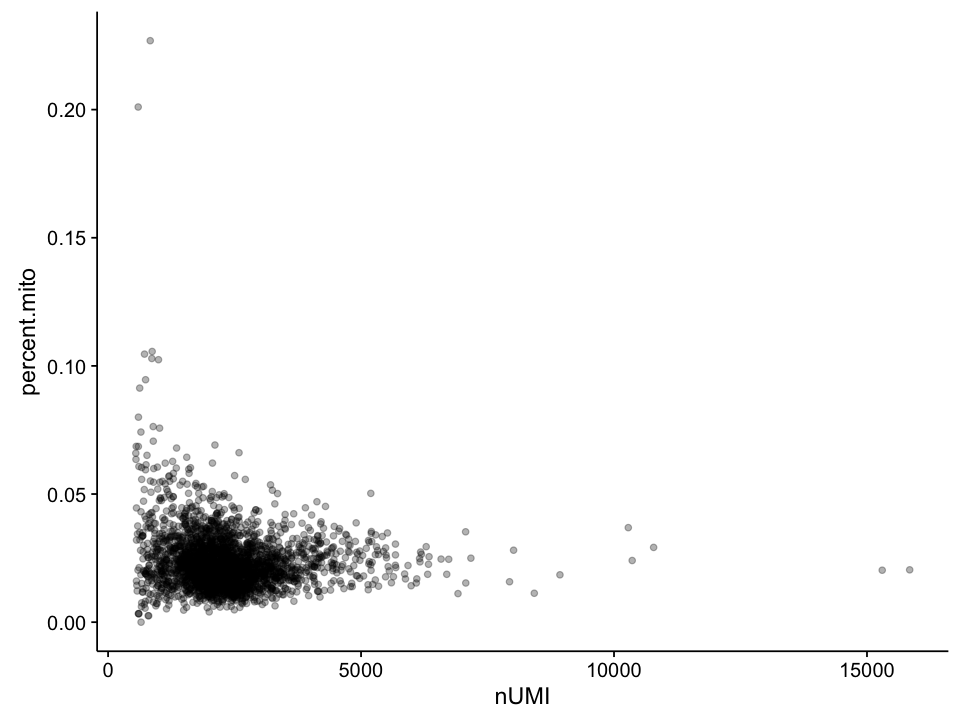

In [29]:
ggplot(meta, aes(x=nUMI, y=percent.mito)) + geom_point(alpha=0.3)

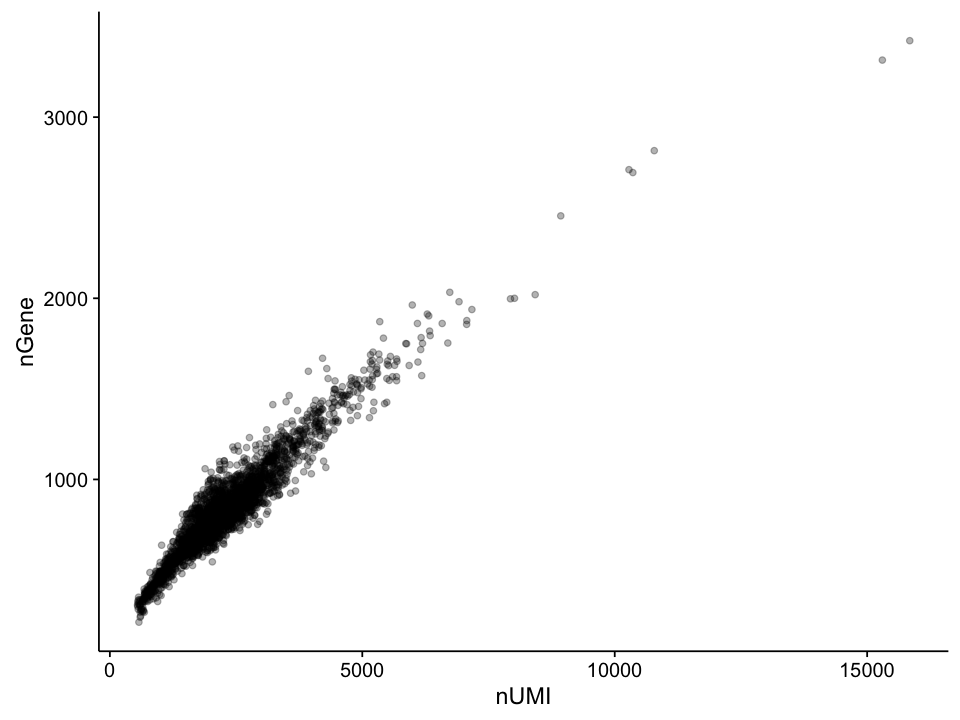

In [30]:
ggplot(meta, aes(x=nUMI, y=nGene)) + geom_point(alpha=0.3)

## QC filters

In [31]:
dim(meta)

[1] 2700    4

In [32]:
pbmc.1 <- SubsetData(pbmc, subset.name = 'nGene', accept.high = 2500)
pbmc.1 <- SubsetData(pbmc.1, subset.name = 'percent.mito', accept.high = 0.05)

In [33]:
dim(pbmc.1@data)

[1] 13714  2626

### We can also do the filtering manually 

In [34]:
idx <- which(meta$nGene < 2500 & meta$percent.mito < 0.05)

In [35]:
pbmc.2 <- pbmc
pbmc.2@data <- pbmc.2@data[,idx]

In [36]:
dim(pbmc.2@data)

[1] 13714  2626

## Regression to eliminate confounding variables

In [37]:
pbmc <- RegressOut(pbmc.1, latent.vars = c('nUMI', 'percent.mito'))

[1] "Regressing out nUMI"         "Regressing out percent.mito"


#### Z-score residuals are stored in scale.data slot

In [38]:
dim(pbmc@scale.data)

[1] 13714  2626

## Detection of variable genes

Seurat plots dispersion against mean to detect highly variable genes. It is not clear what measure of dispersion is used.

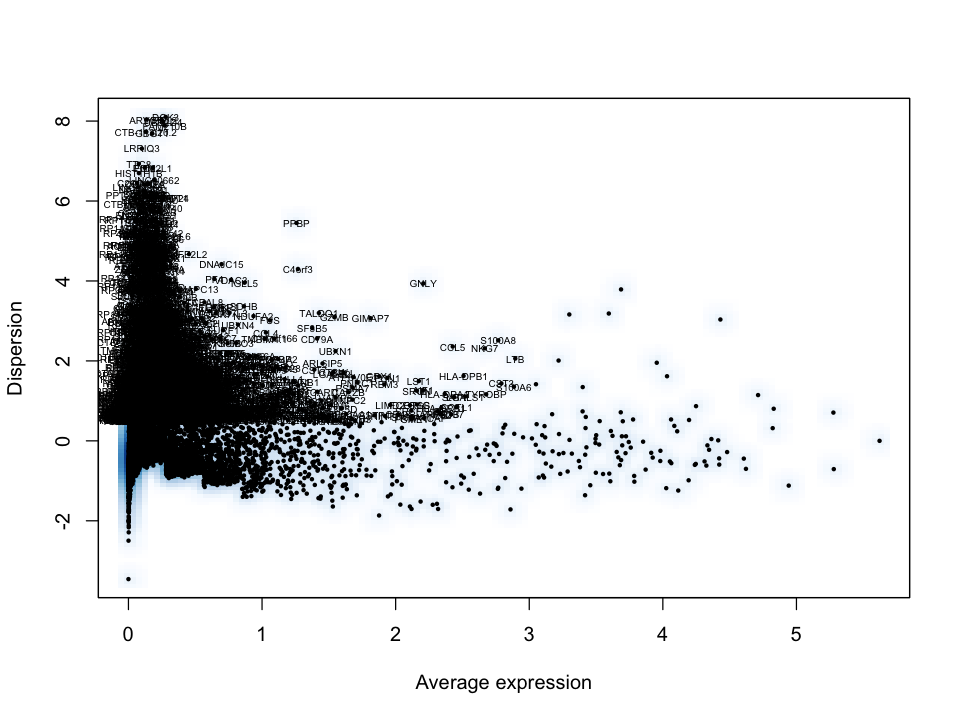

In [39]:
pbmc <- MeanVarPlot(pbmc, fxn.x = expMean, fxn.y = logVarDivMean,
                    x.low.cutoff = 0.0125, x.high.cutoff = 3, 
                    y.cutoff = 0.5, do.contour = F)

In [40]:
length(pbmc@var.genes)

[1] 1842

In [41]:
mu <- apply(pbmc@data, 1, mean)
sigma <- apply(pbmc@data, 1, sd)

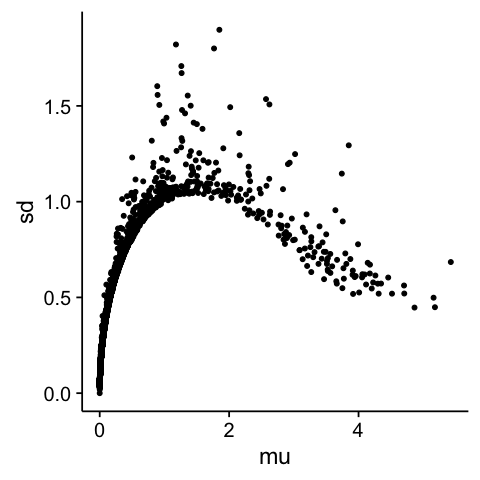

In [42]:
options(repr.plot.width=4, repr.plot.height=4)

ggplot(data.frame(mu=mu, sd=sigma), aes(x=mu, y=sd)) +
geom_point(alpha=01, size=1)

## Dimension reduction

### Find genes with largest weights in each principal component

In [43]:
pbmc <- PCA(pbmc, pc.genes = pbmc@var.genes, 
            do.print = TRUE, pcs.print = 5, genes.print = 5)

[1] "PC1"
[1] "CST3"   "FCN1"   "TYROBP" "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC3"
[1] "HLA-DPA1" "TYROBP"   "FCN1"     "HLA-DRB1" "HLA-DPB1"
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "GNG11" "SPARC"
[1] ""
[1] ""
[1] "PC4"
[1] "IL32"   "AQP3"   "MAL"    "FYB"    "GIMAP7"
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "HLA-DPB1" "MS4A1"   
[1] ""
[1] ""
[1] "PC5"
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] ""


### Visualizing PCA

In [52]:
PrintPCA(pbmc, pcs.print = 1:5, genes.print = 5, use.full = TRUE)

[1] "PC1"
[1] "CST3"   "S100A9" "FTL"    "FCN1"   "TYROBP"
[1] ""
[1] "MALAT1"  "RPS27A"  "PTPRCAP" "RPSA"    "RPS3A"  
[1] ""
[1] ""
[1] "PC2"
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC3"
[1] "RPL10" "RPS2"  "RPL11" "RPL28" "RPL32"
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "GNG11" "SPARC"
[1] ""
[1] ""
[1] "PC4"
[1] "CD3D"  "LDHB"  "IL7R"  "RPS14" "CD3E" 
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "CD74"     "HLA-DPB1"
[1] ""
[1] ""
[1] "PC5"
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] "FCGR3A" "CDKN1C" "MS4A7"  "HES4"   "CKB"   
[1] ""
[1] ""


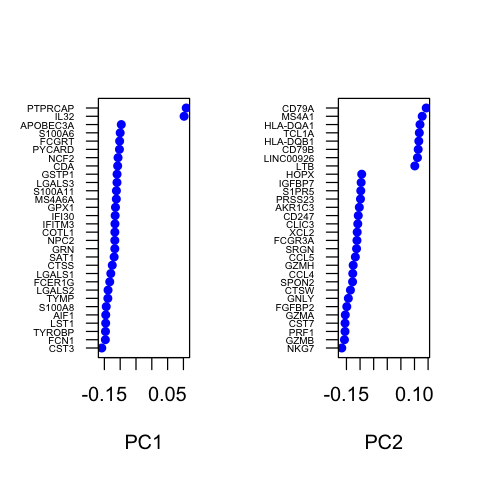

In [46]:
VizPCA(pbmc, 1:2)

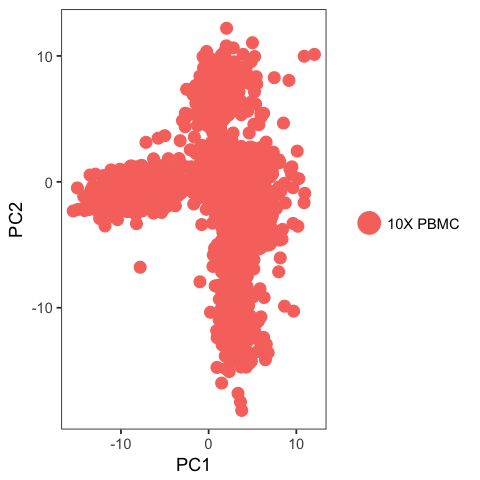

In [47]:
PCAPlot(pbmc, 1, 2)

In [55]:
options(repr.plot.width=8, repr.plot.height=6)

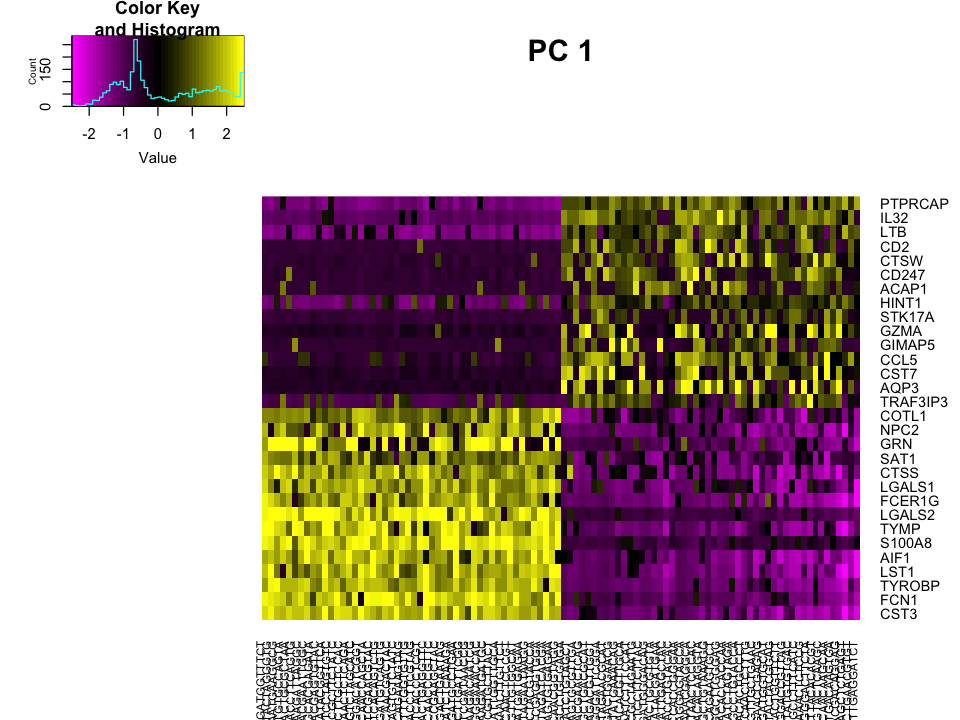

In [56]:
suppressWarnings(
    PCHeatmap(pbmc, pc.use = 1, cells.use = 100, do.balanced = TRUE))

In [61]:
options(repr.plot.width=8, repr.plot.height=6)

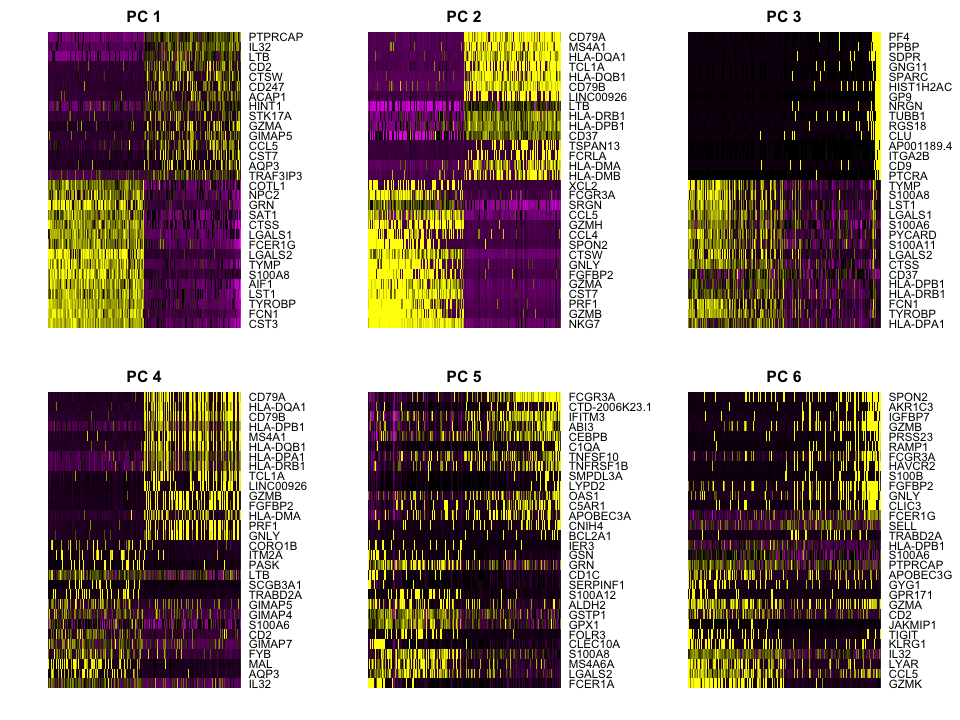

In [62]:
suppressWarnings(
    PCHeatmap(pbmc, pc.use = 1:1:6, cells.use = 500, do.balanced = TRUE,
          label.columns = FALSE, use.full = FALSE))

### Accessing PCA raw data

In [66]:
head(pbmc@pca.rot[, 1:6])

,PC1,PC2,PC3,PC4,PC5,PC6
AAACATACAACCAC,5.6102336,0.1947176,0.08044593,-2.8545619,-0.01778947,0.2716842
AAACATTGAGCTAC,7.4792276,8.2744151,0.25720427,7.5523774,-3.13686700,0.3652463
AAACATTGATCAGC,2.7087828,-1.7157818,0.60993567,-2.2399648,1.92552820,-1.8666199
AAACCGTGCTTCCG,-10.0558852,-1.4840583,-1.27309444,0.8330815,2.85337022,-0.2960447
AAACCGTGTATGCG,-0.9905477,-7.9379511,-1.42060949,4.8574150,-1.83593450,5.9542094
AAACGCACTGGTAC,1.6309377,1.9427900,-0.69032280,-2.5603427,-1.65967245,-0.5630732


### Finding statistically significant PCA components

#### Using an elbow plot

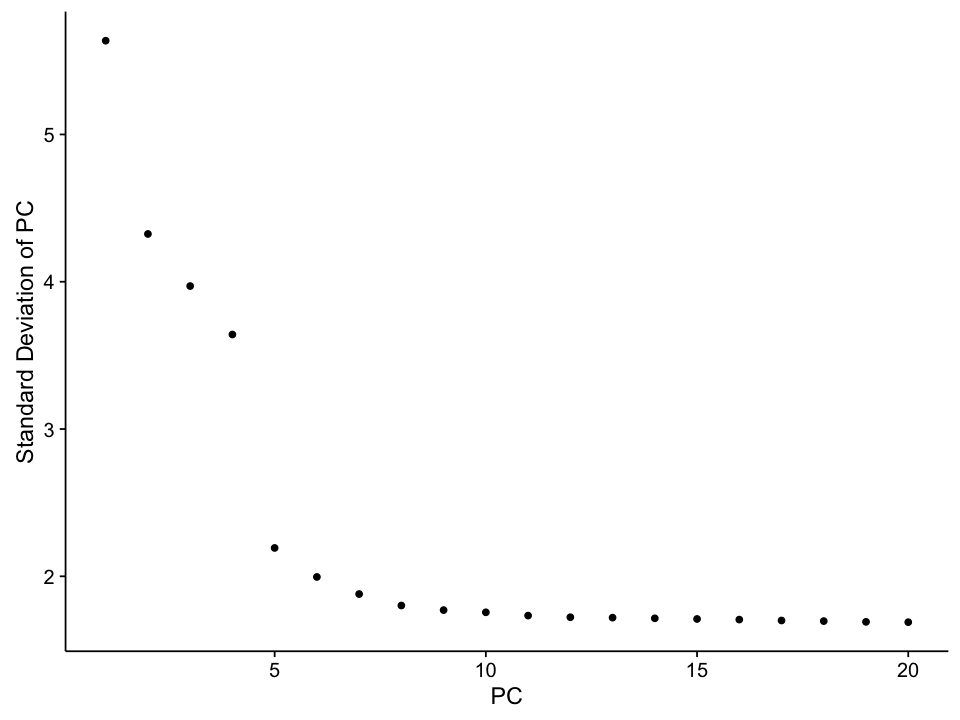

In [74]:
PCElbowPlot(pbmc)

#### Using a permutation test

In [72]:
pbmc <- JackStraw(pbmc, num.replicate = 100, do.print = FALSE)

Warning message in prop.test(c(length(which(pAll[, i] <= score.thresh)), floor(nrow(pAll) * :
“Chi-squared approximation may be incorrect”Warning message in prop.test(c(length(which(pAll[, i] <= score.thresh)), floor(nrow(pAll) * :
“Chi-squared approximation may be incorrect”Warning message in prop.test(c(length(which(pAll[, i] <= score.thresh)), floor(nrow(pAll) * :
“Chi-squared approximation may be incorrect”Warning message:
“Removed 17426 rows containing missing values (geom_point).”

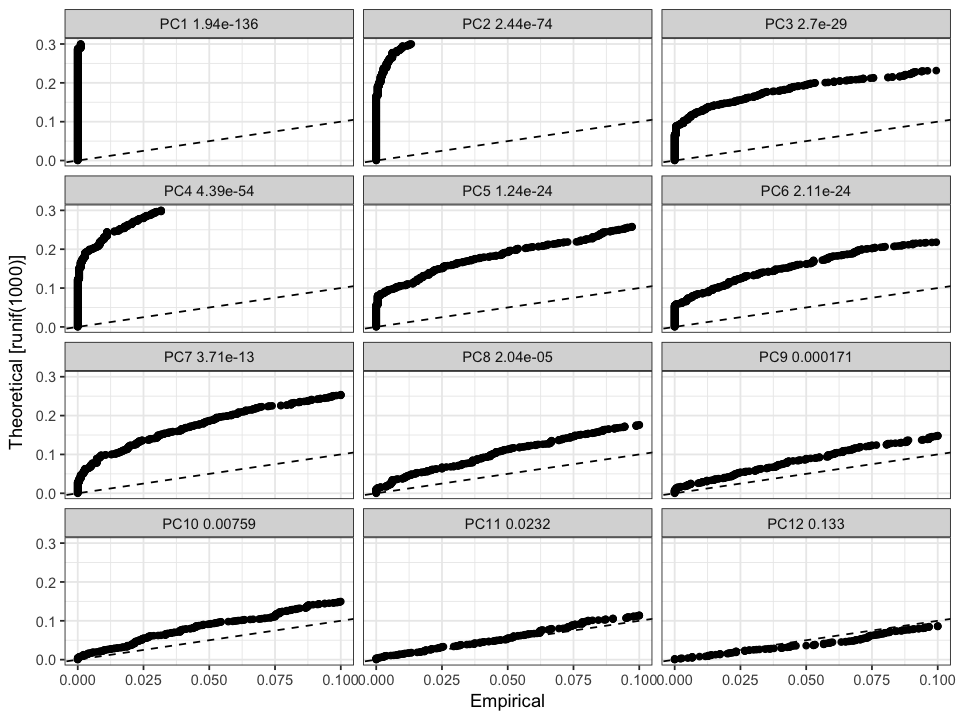

In [73]:
JackStrawPlot(pbmc, PCs = 1:12)

## Clustering cells

In [80]:
pbmc <- FindClusters(pbmc, pc.use = 1:10, resolution = 0.6, 
                     print.output = 0, save.SNN = T)

## Dimension reduction with t-stochastic neighbor embedding

In [81]:
pbmc <- FindClusters(pbmc, pc.use = 1:10, resolution = 0.6,
                     print.output = 0, save.SNN = T)

In [84]:
pbmc <- RunTSNE(pbmc)

sigma summary: Min. : 0.147042148227038 |1st Qu. : 0.222755451774139 |Median : 0.272743672019326 |Mean : 0.288040284221345 |3rd Qu. : 0.330781656546741 |Max. : 1.41769659055075 |
Epoch: Iteration #100 error is: 15.5733828942875
Epoch: Iteration #200 error is: 1.23590191352397
Epoch: Iteration #300 error is: 1.03306148132168
Epoch: Iteration #400 error is: 0.945743412905899
Epoch: Iteration #500 error is: 0.91022735998008
Epoch: Iteration #600 error is: 0.890946844725079
Epoch: Iteration #700 error is: 0.878882151758973
Epoch: Iteration #800 error is: 0.8705685536614
Epoch: Iteration #900 error is: 0.86447147332624
Epoch: Iteration #1000 error is: 0.85972451597676


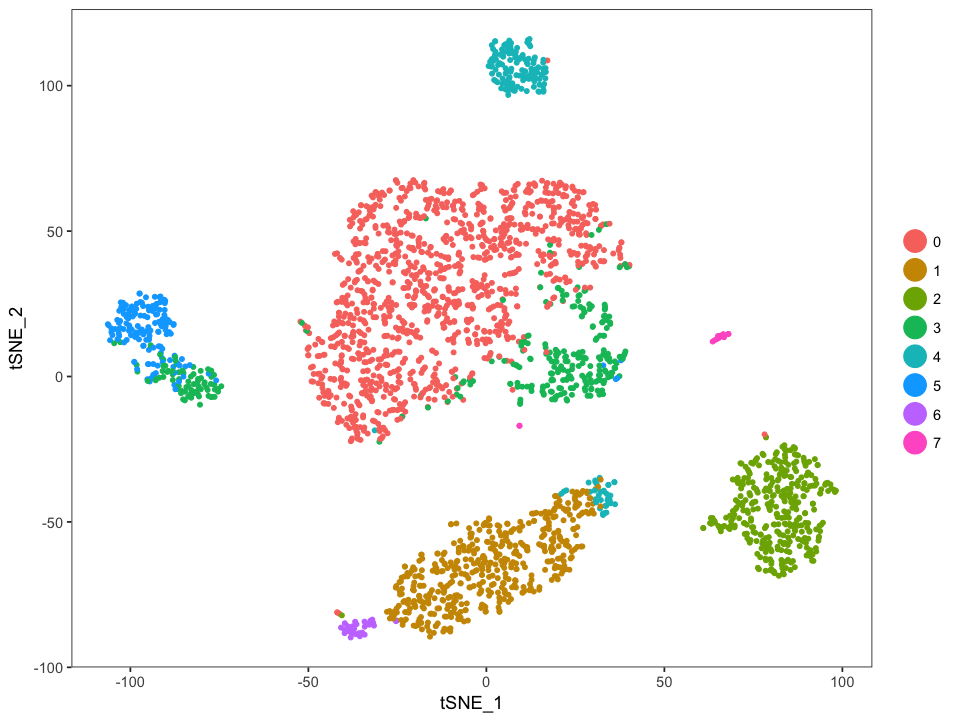

In [85]:
TSNEPlot(pbmc)

In [86]:
save(pbmc, file = "data/seurat/pbmc_tutorial.Robj")

## Finding differentially expressed genes

### Find markers that define clusters via differential expression.

Find all markers of cluster 1

In [87]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)

In [88]:
head(cluster1.markers, 5)

,p_val,avg_diff,pct.1,pct.2
S100A9,0,3.821048,0.996,0.216
S100A8,0,3.741863,0.973,0.123
LYZ,0,3.117188,1.000,0.519
LGALS2,0,2.638905,0.912,0.060
FCN1,0,2.370412,0.958,0.150


Find all markers distinguishing cluster 5 from clusters 0 and 3

In [89]:
cluster5.markers <- FindMarkers(pbmc, 5, c(0,3), min.pct = 0.25)

In [90]:
head(cluster5.markers, 5)

,p_val,avg_diff,pct.1,pct.2
RPS12,8.978753e-171,-1.0307669,0.993,1.000
GNLY,9.014098e-171,3.5003394,0.967,0.142
RPS27,1.267052e-159,-0.9293012,0.987,0.999
NKG7,1.607593e-158,2.3638012,1.000,0.306
GZMB,2.874675e-158,3.2171796,0.954,0.084


Find markers for every cluster compared to all remaining cells, report only the positive ones

In [91]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, 
                               min.pct = 0.25, thresh.use = 0.25)

In [92]:
pbmc.markers %>% group_by(cluster) %>% top_n(2, avg_diff)

p_val,avg_diff,pct.1,pct.2,cluster,gene
4.080951e-268,1.148075,0.927,0.482,0,LDHB
3.225479e-131,1.064684,0.662,0.204,0,IL7R
0.000000e+00,3.821048,0.996,0.216,1,S100A9
0.000000e+00,3.741863,0.973,0.123,1,S100A8
0.000000e+00,2.982570,0.938,0.042,2,CD79A
7.207022e-189,2.484704,0.621,0.022,2,TCL1A
3.833015e-230,2.168980,0.971,0.228,3,CCL5
4.184535e-121,2.086575,0.579,0.051,3,GZMK
2.502877e-163,2.148019,1.000,0.316,4,LST1
3.683692e-136,2.272460,0.955,0.138,4,FCGR3A


### Statistical tests

In [93]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, thresh.use = 0.25,
                                test.use = "roc",only.pos = T)

### Visualize marker expression

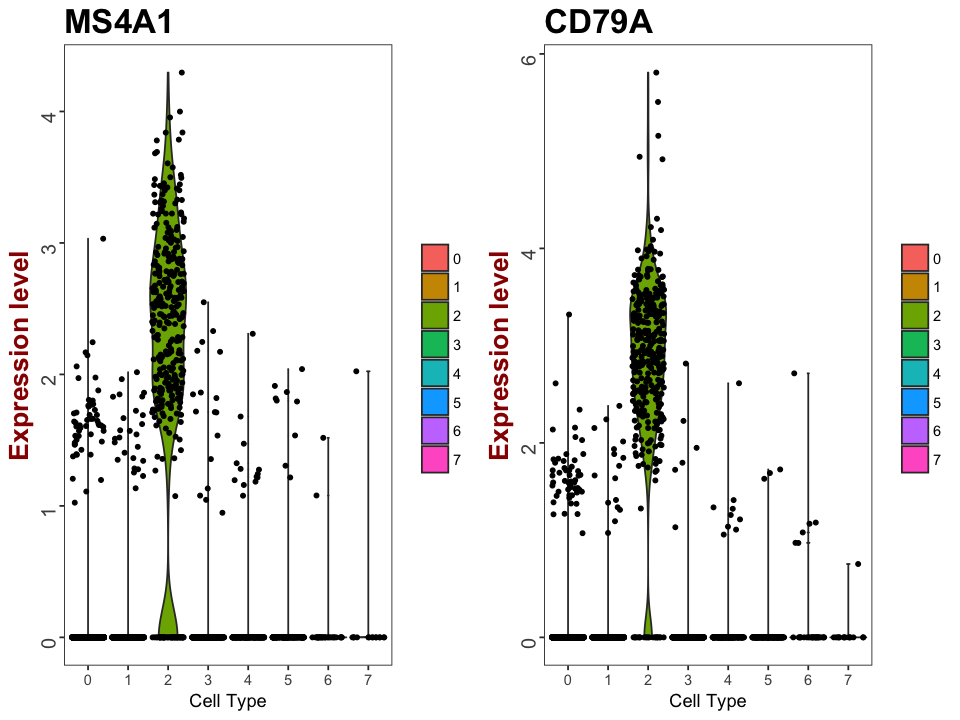

In [94]:
VlnPlot(pbmc, c("MS4A1","CD79A"))

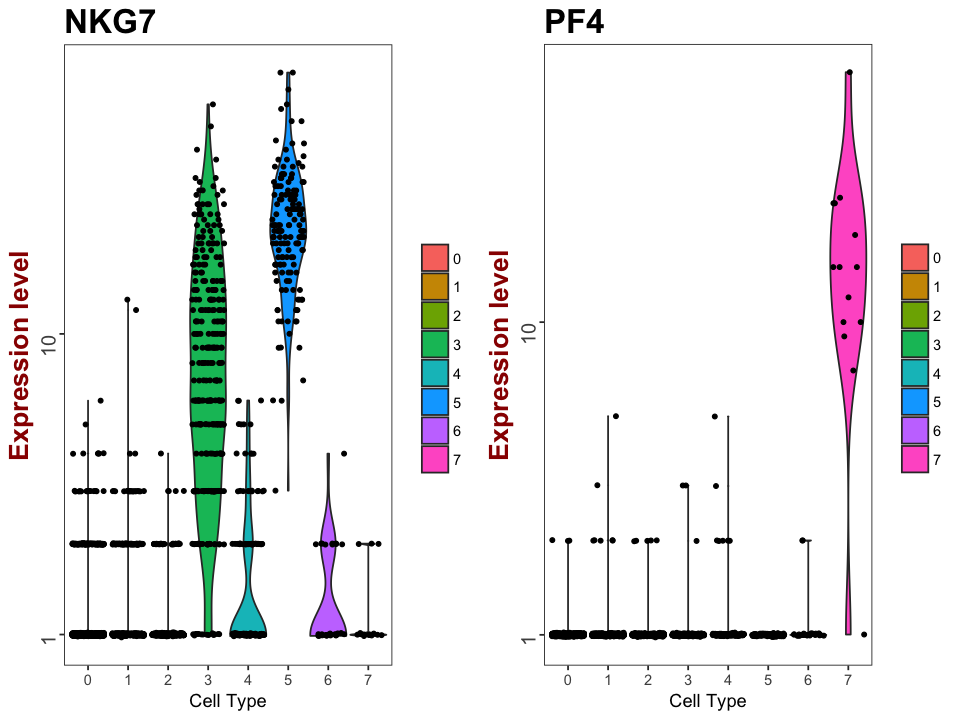

In [95]:
VlnPlot(pbmc, c("NKG7","PF4"),use.raw = T,y.log = T)

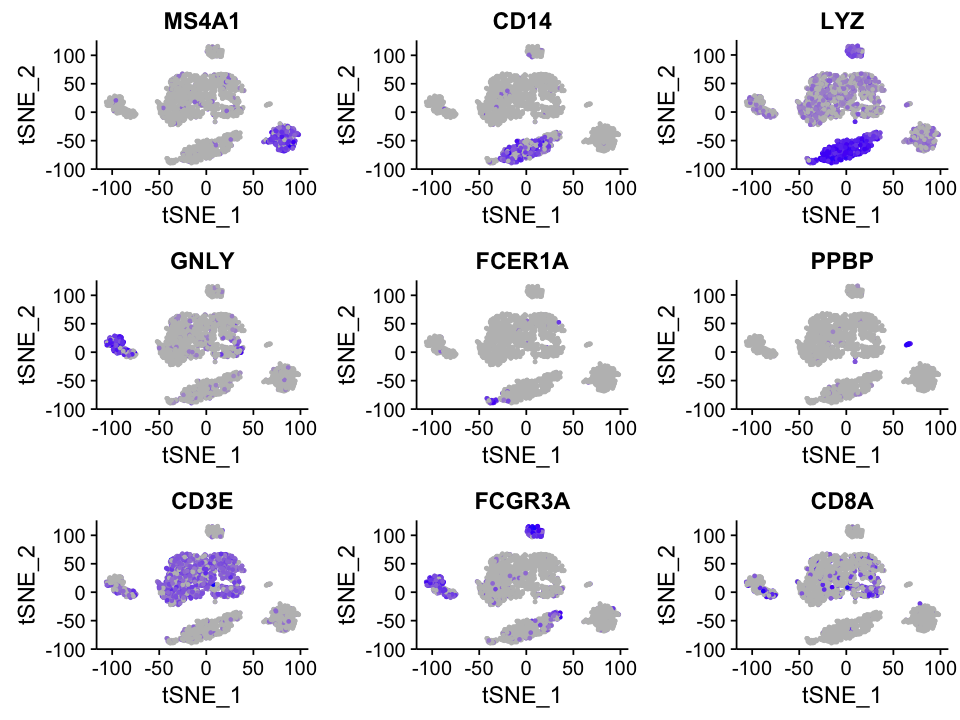

In [96]:
FeaturePlot(pbmc, c("MS4A1", "GNLY","CD3E","CD14","FCER1A",
                    "FCGR3A", "LYZ", "PPBP", "CD8A"),
            cols.use = c("grey","blue"))

#### Heatmaps

In [97]:
pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_diff) -> top10

Warning message in hmFunction(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in hmFunction(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Colv is FALSE, while dendrogram is `none'. Omitting column dendogram.”

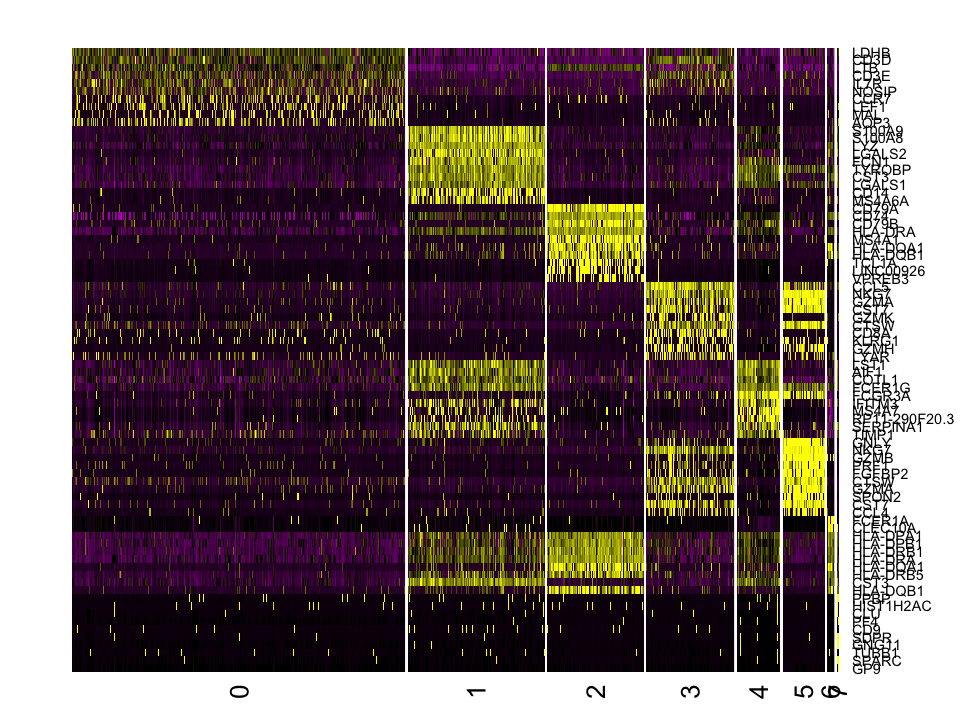

In [98]:
DoHeatmap(pbmc, genes.use = top10$gene, order.by.ident = TRUE,
          slim.col.label = TRUE, remove.key = TRUE)

## Manual assignment of cell type identity to clusters

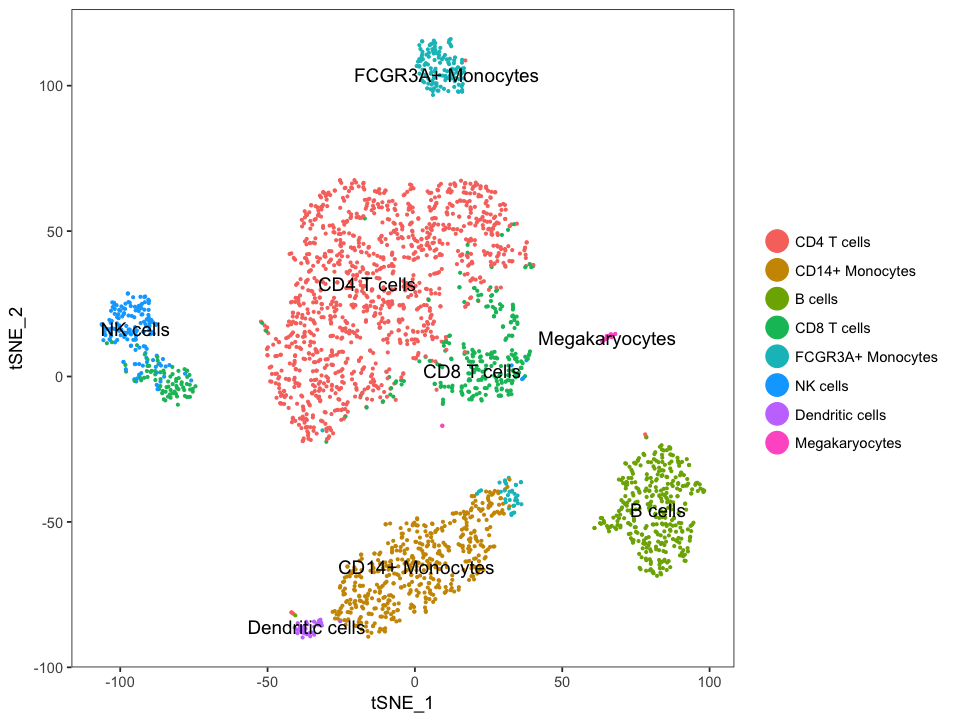

In [99]:
current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)
new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes", "B cells",
                     "CD8 T cells", "FCGR3A+ Monocytes", "NK cells",
                     "Dendritic cells", "Megakaryocytes")
pbmc@ident <- plyr::mapvalues(pbmc@ident, 
                              from = current.cluster.ids, 
                              to = new.cluster.ids)
TSNEPlot(pbmc, do.label = T, pt.size = 0.5)

### Stashing identities for easy recovery when exploring possible annotations

In [100]:
pbmc <- StashIdent(pbmc, save.name = "ClusterNames_0.6")

In [101]:
pbmc <- FindClusters(pbmc, pc.use = 1:10, 
                     resolution = 0.8, print.output = F)

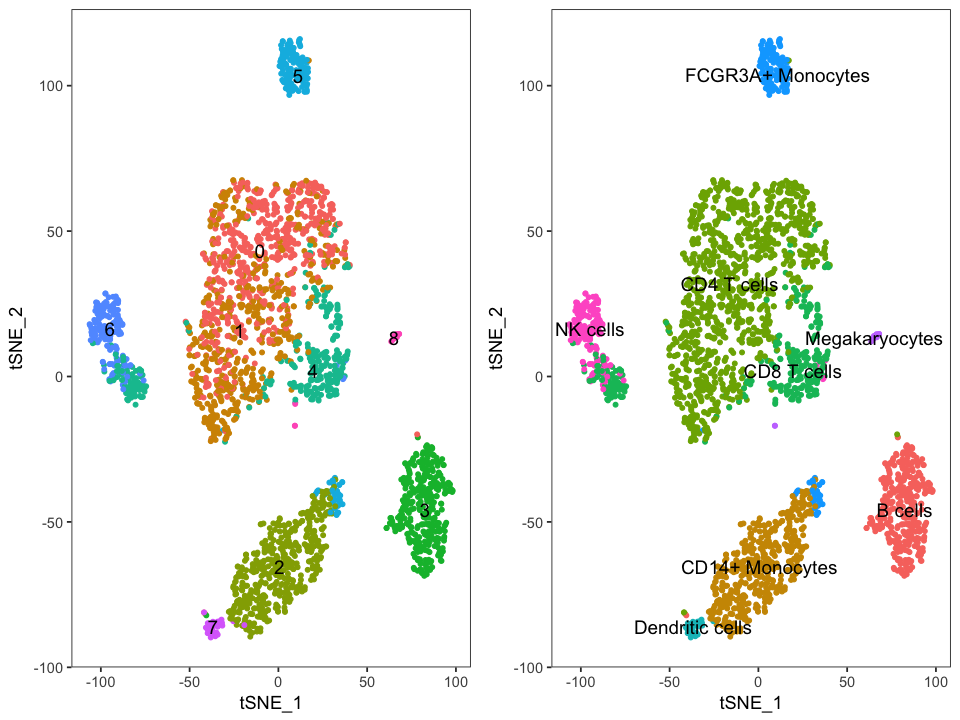

In [102]:
plot1 <- TSNEPlot(pbmc, do.return = T, no.legend = TRUE, do.label = T)
plot2 <- TSNEPlot(pbmc, do.return = T, group.by = "ClusterNames_0.6", 
                  no.legend = TRUE, do.label = T)
MultiPlotList(list(plot1, plot2), cols = 2)

Find discriminating markers

In [103]:
tcell.markers <- FindMarkers(pbmc, 0, 1)

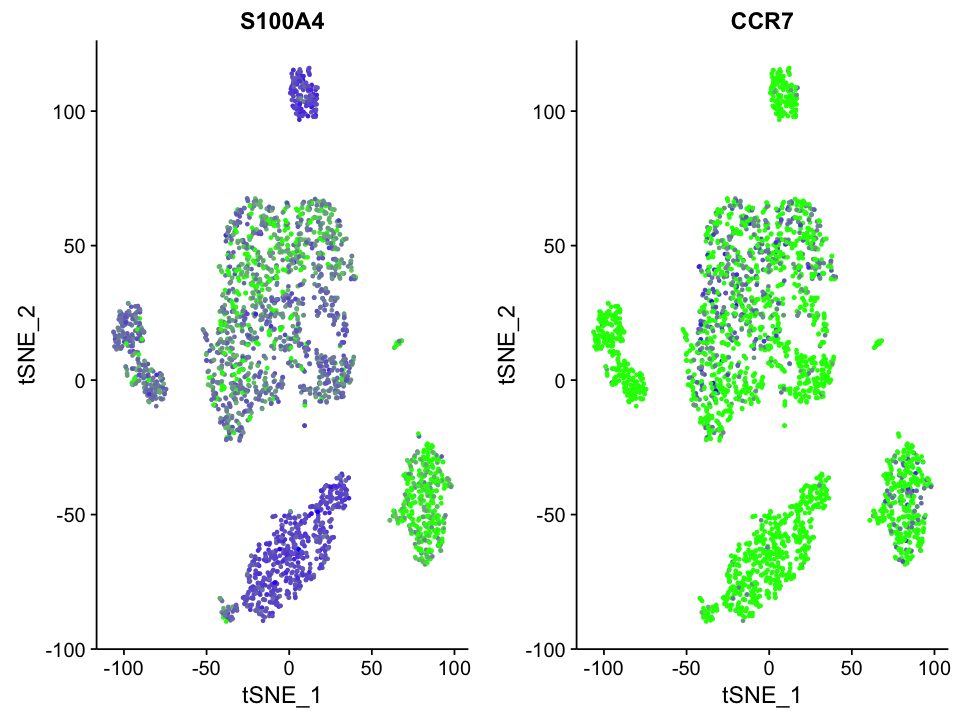

In [104]:
FeaturePlot(pbmc, c("S100A4", "CCR7"),
            cols.use = c("green", "blue"))

### Restore old cell identities

In [105]:
pbmc <- SetAllIdent(pbmc, id = "ClusterNames_0.6")